This notebook addresses the question, "Can we represent a molecule as a graph via a 1D column vector or a 2D matrix of fixed length, with maximum number of atoms n_rows?" Then, can we use this representation to learn neural fingerprints? E.g., can we make an aromatic ring detector? 

Scheme:
feature_matrix = X
for each ligand:
    choose a central atom. this can be the atom (node) that minimizes distance to furthest heavy atom in graph.
    set first row of X to be this central atom
    set next four rows to be the atoms bonded to that centrl atom
        set zeros for rows where row ind > n_bonds of atom
    for each of those atoms:
        repeat. find their neighbors. add to matrix.

algorithm: breadth-first search:
1. create networkx graph based on molecule
2. find "central" atom (different strategies)
3. define atom matrix of size (1+4+4*3^(L-1)) x (n_features_per_atom)
4. start atom queue q
5. central_atom.layer = 0; central_atom.row_idx = 0;
6. q.enqueue(central_atom)
7. define adjacency matrix of size (1+4+4*3^(L-1)) x 4

def get_row_idx(curr_layer, prev_row_idx, curr_neighbor_idx):
    if curr_layer == 0:
        return(0)
    if curr_layer == 1:
        row_idx = 1 + curr_neighbor_idx
    if layer == 2:
        last_max = 5
        row_idx = last_max + (3*(prev_row_idx-last_max)) + curr_neighbor_idx
    if layer > 2:
        last_max = 5 + 4*3^(curr_layer-2) 
        row_idx = last_max + 3*(prev_row_idx-last_max) + curr_neighbor_idx
    return(row_idx)
    

while q.is_not_empty():
    a = q.dequeue()
    a.visited = True
    for n_idx, n in enumerate(a.neighbors()):
        if not n.visited:
            row_idx = c
            n.layer = a.layer + 1
            row_idx = get_row_idx(n.layer, a.row_idx, n_idx)
            n.row_idx = row_idx
            adj_matrix[a.row_idx][n_idx] = n.row_idx
            atom_matrix[row_idx][elem_to_idx[n.elem]] = 1

input_matrix = tf.concat([atom_matrix, atom_matrix[adj_matrix[:,0]], atom_matrix[adj_matrix[:,1]], atom_matrix[adj_matrix[:,2]], atom_matrix[adj_matrix[:,3]]

neural net:
h1 = relu([tf.zeros([n_features_per_atom, 4]) * input_matrix + bias))
h1_conc = tf.concat([h1, h1[adj_matrix[:,0], ..., h1[adj_matrix[:,3])

repeat h1 to get h2


dihedral predictor pseudocode:

get bonds for molecule
create networkx graph out of molecule (use atom indices)

for each edge:
   for neighbor_i in atom_i.neighbors():
       if neighbor_i == atom_j: continue
       for neighbor_j in atom_j.neighbors():
           if neighbor_j == atom_i: continue
           dihedrals.append((neighbor_i, atom_i, neighbor_j, atom_j))
           check to make sure (atom_j, neighbor_j, atom_i, neighbor_i)) not already in list

for dihedral in dihedrals:
    angle =  rdMolTransforms.GetDihedralDeg(c, 0,1,2,3)


In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolTransforms
import os
import fnmatch
import numpy as np
import deepchem as dc
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.mixture import GMM


In [43]:
def get_torsions_angles(mol, n_bonds=100, n_atoms=200):
    c = mol.GetConformer(0)

    torsions = []
    torsion_tuples = []
    
    torsion_matrix = np.zeros((n_bonds,6))
    torsion_indices = np.zeros((n_bonds,n_atoms,24)).astype(np.uint8)
    
    bond_adjacency = np.zeros((n_bonds,n_bonds)).astype(np.uint8)
    for idx, bond in enumerate(mol.GetBonds()):
        if bond.IsInRing(): 
            continue

        def calc_torsions(atom_i, atom_j, bond_idx, start=0):        
            exist_dihed = False
            for neighbor_j in atom_j.GetNeighbors():
                if neighbor_j.GetIdx() == atom_i.GetIdx():
                    continue

                dihed_idx = 0
                for neighbor_i in atom_i.GetNeighbors():
                    if neighbor_i.GetIdx() == atom_j.GetIdx():
                        continue

                    exist_dihed=True
                    torsion_tuple = (neighbor_i.GetIdx(), atom_i.GetIdx(), atom_j.GetIdx(), neighbor_j.GetIdx())

                    torsion_matrix[bond_idx][3*start+dihed_idx] = np.cos(rdMolTransforms.GetDihedralRad(c, *torsion_tuple))
                    torsion_indices[bond_idx][torsion_tuple[0]][12*start+dihed_idx*4] = 1
                    torsion_indices[bond_idx][torsion_tuple[1]][12*start+dihed_idx*4+1] = 1
                    torsion_indices[bond_idx][torsion_tuple[2]][12*start+dihed_idx*4+2] = 1
                    torsion_indices[bond_idx][torsion_tuple[3]][12*start+dihed_idx*4+3] = 1
                    dihed_idx += 1
                #torsion_matrix[bond_idx][3] = 3.14159 - np.abs(np.abs(torsion_matrix[bond_idx][2]-torsion_matrix[bond_idx][1])-3.14159)
                #torsion_matrix[bond_idx][4] = 3.14159 - np.abs(np.abs(torsion_matrix[bond_idx][2]-torsion_matrix[bond_idx][0])-3.14159)
                #torsion_matrix[bond_idx][5] = 3.14159 - np.abs(np.abs(torsion_matrix[bond_idx][1]-torsion_matrix[bond_idx][0])-3.14159)
                break
        
        calc_torsions(bond.GetBeginAtom(), bond.GetEndAtom(), idx, 0)
        calc_torsions(bond.GetEndAtom(), bond.GetBeginAtom(), idx, 1)
    
        atom_i_bonds = bond.GetBeginAtom().GetBonds()
        atom_j_bonds = bond.GetEndAtom().GetBonds()

        for bond_i in atom_i_bonds:
            if bond_i.GetIdx() != bond.GetIdx():
                bond_adjacency[bond.GetIdx()][bond_i.GetIdx()] = 1.
                bond_adjacency[bond_i.GetIdx()][bond.GetIdx()] = 1.
        for bond_j in atom_j_bonds:
            if bond_j.GetIdx() != bond.GetIdx():
                bond_adjacency[bond.GetIdx()][bond_j.GetIdx()] = 1.
                bond_adjacency[bond_j.GetIdx()][bond.GetIdx()] = 1.    
    
    
    return((torsion_indices, csr_matrix(torsion_matrix), csr_matrix(bond_adjacency)))
                

In [44]:
def featurize_mols(mol_files):
    featurizer = AdjacencyFingerprint(max_n_atoms=200)
    features = []
    for idx, mol_file in enumerate(mol_files):
        if idx % 100 == 0:
            print(idx)
        if 1==1:
            mol = Chem.MolFromMol2File(mol_file)
            if mol is None:
                features.append(None)
                continue
            torsions = get_torsions_angles(mol)
            graph_feat = featurizer.featurize([mol])[0]
            features.append((mol_file, torsions, graph_feat))
        else:
            features.append(None)
    return(features)

In [45]:
from deepchem.feat.graph_features import ConvMolFeaturizer
from deepchem.feat.adjacency_fingerprints import AdjacencyFingerprint

In [46]:
import pickle
feature_file = "./dihedral_features_pdbbind.pkl"
#if not os.path.exists(feature_file):
if 1== 1:
    pdbbind_dir = "/home/evan/Documents/deep_docking/datasets/v2015/"
    def find_files(directory, pattern):
        for root, dirs, files in os.walk(directory):
            for basename in files:
                if fnmatch.fnmatch(basename, pattern):
                    filename = os.path.join(root, basename)
                    yield filename
    ligand_files = [f for f in find_files(pdbbind_dir, "*ligand.mol2")][:1]
    features = featurize_mols(ligand_files)
    with open(feature_file, "wb") as f:
        pickle.dump(features, f, protocol=2)
else:
    with open(feature_file, "rb") as f:
        features = pickle.load(f)

0


In [47]:
features = [f for f in features if f is not None]

In [48]:
features[0][1][1].toarray()

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.61143659, -0.99900387,  0.48252666,  0.61143659,  0.        ,
         0.        ],
       [-0.97974276,  0.46090066,  0.58913924, -0.97974276,  0.97948206,
         0.        ],
       [ 0.0092509 ,  0.        ,  0.        ,  0.0092509 , -0.87576691,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.

In [38]:
len(features)

1

In [10]:
import tensorflow as tf
alpha = 0.01
n_layers = 0
S = 64
B = 200
L_list = [50, 50, 50, 50]
p = 75
n_bonds=100

x = tf.placeholder(tf.float32, shape=[S, B, p])

non_zero_inds = tf.placeholder(tf.int32, shape=[None, S*n_bonds])

adj_matrix = tf.placeholder(tf.float32, shape=[S, B, B])
dihed_indices = tf.placeholder(tf.float32, shape=[S, n_bonds, B, 12])

label_placeholder = tf.placeholder(
    dtype='float32', shape=[None,3], name="label_placeholder")

phase = tf.placeholder(dtype='bool', name='phase')

z = tf.placeholder(tf.float32,
                          [None, 200, 75], name='z')

z_ini = tf.placeholder(tf.float32,
                          [None, 200, 75], name='z_ini')

ones_like = tf.placeholder(tf.float32, shape=[None,1])
zeros_like = tf.placeholder(tf.float32, shape=[None,1])


In [11]:
#DISCRIMINATOR


D_W_list = [None for i in range(n_layers)]
D_b_list = [None for i in range(n_layers)]
D_h_list = [None for i in range(n_layers)]



for layer_idx in range(n_layers):
    if layer_idx == 0:
      L_in = p
      L_out = L_list[0]
      atom_matrix = x
    else:
      L_in = L_list[layer_idx-1]
      L_out = L_list[layer_idx]
      atom_matrix = D_h_list[layer_idx-1]

    D_W_list[layer_idx] = tf.Variable(tf.truncated_normal([L_in, L_out], seed=2017), name="D_W_list%d" %layer_idx)
    D_b_list[layer_idx] = tf.Variable(tf.zeros([1, L_out]))

    
D_W2 = tf.Variable(tf.truncated_normal([L_list[-1]*12+3, 100]))
D_b2 = tf.Variable(tf.zeros([1, 100]))

D_W3 = tf.Variable(tf.truncated_normal([100, 3]))
D_b3 = tf.Variable(tf.zeros([1, 3]))

D_W4 = tf.Variable(tf.truncated_normal([3, 10]))
D_b4 = tf.Variable(tf.zeros([1, 10]))

D_W5 = tf.Variable(tf.truncated_normal([10, 1]))
D_b5 = tf.Variable(tf.zeros([1, 1]))

"""

D_W0 = tf.Variable(tf.truncated_normal([3, 100]))
D_b0 = tf.Variable(tf.zeros([1,100]))

D_W1 = tf.Variable(tf.truncated_normal([100, 100]))
D_b1 = tf.Variable(tf.zeros([1,100]))

D_W2 = tf.Variable(tf.truncated_normal([100, 1]))
D_b2 = tf.Variable(tf.zeros([1,1]))

def adjacency_conv_layer(atom_matrix, W, b, L_in, L_out, layer_idx, is_training=True):
    print("layer_idx: %d" %(layer_idx))
    h = tf.matmul(adj_matrix, atom_matrix, name="adj_conv1")
    h = tf.reshape(h, shape=(S*B, L_in))

    h = tf.matmul(h, W) + b
    h = tf.maximum(alpha*h, h)
    
    h = tf.reshape(h, (S, B, L_out))
    #h = tf.contrib.layers.batch_norm(h, 
    #                                    center=True, scale=False, 
    #                                    is_training=is_training)

    return(h)

def discriminator(angles, is_training=True):
    D_h0 = tf.matmul(angles, D_W0) + D_b0
    D_h0 = tf.maximum(alpha*D_h0, D_h0)

    D_h1 = tf.matmul(D_h0, D_W1) + D_b1
    D_h1 = tf.maximum(alpha*D_h1, D_h1)
    
    D_h2 = tf.matmul(D_h1, D_W2) + D_b2
    #D_h2 = tf.maximum(alpha*D_h2, D_h2)
    
    return(D_h2)
    
    """
    
    for layer_idx in range(n_layers):
        if layer_idx == 0:
          L_in = p
          L_out = L_list[0]
          atom_matrix = x
        else:
          L_in = L_list[layer_idx-1]
          L_out = L_list[layer_idx]
          atom_matrix = D_h_list[layer_idx-1]
        
        D_h_list[layer_idx] = adjacency_conv_layer(atom_matrix, D_W_list[layer_idx], D_b_list[layer_idx], L_in, L_out, layer_idx)

    L_final = L_list[n_layers-1]
    h_final = tf.reshape(D_h_list[layer_idx], (S, B, L_final))

    #add dihedral regressor layers

    d0 = []
    for i in range(0, S):
        mol_tuple = []
        for j in range(0, 12):
          entry = h_final[i]
          indices = dihed_indices[i][:,:,j]
          atom_list = tf.matmul(indices, entry, name="disc1")
          atom_list = tf.reshape(atom_list, (n_bonds, L_final))
          mol_tuple.append(atom_list)
        mol_tuple = tf.reshape(tf.stack(mol_tuple, axis=1), (n_bonds, L_final*12))
        d0.append(mol_tuple)

    d0 = tf.concat(d0, axis=0)
    d0 = tf.concat([d0, angles], axis=1)
    d0 = tf.matmul(tf.cast(non_zero_inds, tf.float32), d0)


    d2 = tf.matmul(d0, D_W2, name="disc2") + D_b2
    d2 = tf.maximum(d2, alpha*d2)

    #d2 = tf.contrib.layers.batch_norm(d2, 
    #                                    center=True, scale=False, 
    #                                    is_training=is_training)
    
    d3 = tf.matmul(d2, D_W3, name="disc3") + D_b3
    d3 = tf.maximum(d3, alpha*d3)
    
    #d3 = tf.nn.tanh(d3)

    #d3 = tf.contrib.layers.batch_norm(d3, 
    #                                    center=True, scale=False, 
    #                                    is_training=is_training)
    
                                                                                                                                                               
    d4 = tf.matmul(d3, D_W4, name="disc3") + D_b4
    
    #
    output = tf.matmul(d4, D_W5, name="disc4") + D_b5
    
    #D_prob = tf.nn.sigmoid(D_logit)
    return(output)
    """



In [12]:
def atan2(y, x, epsilon=1.0e-12):
  # Add a small number to all zeros, to avoid division by zero:
  x = tf.where(tf.equal(x, 0.0), x+epsilon, x)
  y = tf.where(tf.equal(y, 0.0), y+epsilon, y)

  angle = tf.where(tf.greater(x,0.0), tf.atan(y/x), tf.zeros_like(x))
  angle = tf.where(tf.logical_and(tf.less(x,0.0),  tf.greater_equal(y,0.0)), tf.atan(y/x) + np.pi, angle)
  angle = tf.where(tf.logical_and(tf.less(x,0.0),  tf.less(y,0.0)), tf.atan(y/x) - np.pi, angle)
  angle = tf.where(tf.logical_and(tf.equal(x,0.0), tf.greater(y,0.0)), 0.5*np.pi * tf.ones_like(x), angle)
  angle = tf.where(tf.logical_and(tf.equal(x,0.0), tf.less(y,0.0)), -0.5*np.pi * tf.ones_like(x), angle)
  angle = tf.where(tf.logical_and(tf.equal(x,0.0), tf.equal(y,0.0)), tf.zeros_like(x), angle)
  return angle

#GENERATOR

G_W_list = [None for i in range(n_layers+1)]
G_b_list = [None for i in range(n_layers+1)]
G_h_list = [None for i in range(n_layers+1)]


L_final = p
for layer_idx in range(n_layers):
    if layer_idx == 0:
      L_in = p
      L_out = L_list[0]
      atom_matrix = x
    else:
      L_in = L_list[layer_idx-1]
      L_out = L_list[layer_idx]
      atom_matrix = G_h_list[layer_idx-1]

    G_W_list[layer_idx] = tf.Variable(tf.truncated_normal([L_in, L_out], seed=2017), name="G_W_list%d" %layer_idx)
    G_b_list[layer_idx] = tf.Variable(tf.zeros([1, L_out]))

    
G_W2 = tf.Variable(tf.truncated_normal([L_final*24, 6]))
G_b2 = tf.Variable(tf.zeros([1, 6]))

#G_W3 = tf.Variable(tf.truncated_normal([100, 3]))
#G_b3 = tf.Variable(tf.zeros([1, 3]))

#G_W4 = tf.Variable(tf.truncated_normal([100, 3]))
#G_b4 = tf.Variable(tf.zeros([1, 3]))


def adjacency_conv_layer(atom_matrix, W, b, L_in, L_out, layer_idx, is_training):
    print("layer_idx: %d" %(layer_idx))
    h = tf.matmul(adj_matrix, atom_matrix, name="gen0_%d" %layer_idx)
    h = tf.reshape(h, shape=(S*B, L_in))

    h = tf.matmul(h, W, name="gen1") + b
    #h = tf.maximum(alpha*h, h)
    h = tf.nn.tanh(h)
    
    h = tf.reshape(h, (S, B, L_out))
    #h = tf.contrib.layers.batch_norm(h, 
    #                                    center=True, scale=False, 
    #                                    is_training=is_training)

    return(h)

def generator(z, is_training=True):
    layer_idx = 0
    atom_matrix = tf.add(x, z)
    G_h_list[0] = atom_matrix
    
    L_final = p
    
    for layer_idx in range(n_layers):
        if layer_idx == 0:
          L_in = p
          L_out = L_list[0]

        else:
          L_in = L_list[layer_idx-1]
          L_out = L_list[layer_idx]
          atom_matrix = G_h_list[layer_idx-1]
        
        G_h_list[layer_idx+1] = gen_adjacency_conv_layer(atom_matrix, G_W_list[layer_idx], G_b_list[layer_idx], L_in, L_out, layer_idx, is_training)
    
    g_h_final = tf.reshape(G_h_list[layer_idx], (S, B, L_final))

    #add dihedral regressor layers

    def mult(idx):
        return(tf.matmul(dihed_indices[:,:,:,tf.cast(idx, tf.int32)], g_h_final))

    elems = np.arange(24).astype(np.float32)
    g_d0 = tf.concat(tf.map_fn(mult, elems), axis=2)
    g_d0 = tf.reshape(g_d0, (S*n_bonds, L_final*24))
    
    
    #g_d0 = []
    #for l in range(0,12):
    #    indices = dihed_indices[:,:,:,l]
    #    g_d0.append(tf.matmul(indices, g_h_final))
    
    #for i in range(0, S):
    #    mol_tuple = []
    #    for j in range(0, 12):
    #      entry = g_h_final[i]
    #      indices = dihed_indices[i][:,:,j]
    #      atom_list = tf.matmul(indices, entry, name='gen2')
    #      atom_list = tf.reshape(atom_list, (n_bonds, L_final))
    #      mol_tuple.append(atom_list)
    #    mol_tuple = tf.reshape(tf.stack(mol_tuple, axis=1), (n_bonds, L_final*12))
    #    g_d0.append(mol_tuple)

    #g_d0 = tf.concat(g_d0, axis=0)
    
    g_d2 = tf.matmul(g_d0, G_W2, name='gen3') + G_b2
    #g_d2 = tf.tanh(g_d2)
    #g_d2 = tf.maximum(alpha*g_d2, g_d2)

    
    #g_d2 = tf.contrib.layers.batch_norm(g_d2, 
    #                                    center=True, scale=False, 
    #                                    is_training=is_training)
    
    #g_d3 = tf.matmul(g_d2, G_W3) + G_b3
    #g_d3 = tf.nn.tanh(g_d3)

    #g_d3 = tf.contrib.layers.batch_norm(g_d3, 
    #                                    center=True, scale=False, 
    #                                    is_training=is_training)
                                                                                                                                                               
    #g_d4 = tf.matmul(g_d3, G_W4) + G_b4
    
    output_i = g_d2
    output = tf.matmul(tf.cast(non_zero_inds, tf.float32), output_i)

    #d3_cos = tf.cos(g_d4)
    #d3_sin = tf.sin(g_d4)
    #output = atan2(d3_sin, d3_cos)
    
    #output = tf.concat([output,
    #                    tf.reshape(3.14159 - tf.abs(tf.abs(output[:,2]-output[:,1])-3.14159), (-1,1)),
    #                    tf.reshape(3.14159 - tf.abs(tf.abs(output[:,2]-output[:,0])-3.14159), (-1,1)),
    #                    tf.reshape(3.14159 - tf.abs(tf.abs(output[:,1]-output[:,0])-3.14159), (-1,1))],
    #                   axis=1)
    print("output")
    print(output)
    
    G_logit = tf.nn.sigmoid(output)

    return(output, output_i)



In [13]:
theta_D = [D_W0, D_W1, D_W2, D_b0, D_b1, D_b2]
#theta_D = [D_W_list[0], D_W2, D_W3, D_W4, D_W5, D_b_list[0], D_b2, D_b3, D_b4, D_b5]

theta_G = [G_W2, G_b2]

In [14]:
gmm = GMM(2, n_iter=1., covariance_type="spherical")

gmm.means_ = np.array([[-10], [10]])
gmm.covars_ = np.array([[0.0001], [0.0001]])

def construct_feed_dict(X, start=None,
                      stop=None, y=None,
                      keep_prob=1.0, train=False):
    if start is None:
      start = 0
      stop = len(X)

    atom_adj_batch = [X[idx][2][0].toarray().astype(np.float32) for idx in range(start, stop)]
    A_batch = [X[idx][2][1].toarray() for idx in range(start, stop)]
    D_batch = [X[idx][1][0] for idx in range(start, stop)]
    y_batch = [X[idx][1][1].toarray() for idx in range(start, stop)]
    bond_adj_batch = [X[idx][1][2].toarray() for idx in range(start, stop)]

    
    y_batch = np.concatenate(y_batch, axis=0)
    non_zero_batch = np.where(y_batch[:,0] != 0.)[0]
    y_batch = y_batch[non_zero_batch]

    y_batch = y_batch + np.random.normal(0, 0.03, size=y_batch.shape)

    onehotter = OneHotEncoder(n_values = S*X[0][1][1].shape[0])
    non_zero_onehot = onehotter.fit_transform(non_zero_batch).toarray().reshape((len(non_zero_batch),S*X[0][1][1].shape[0]))
    
    z_batch = np.random.uniform(-0.1, 0.1, size=(S, adj[0].shape[0],75))
    
    feed_dict = {x: A_batch,
                 adj_matrix: atom_adj_batch,
                 phase: train,
                 label_placeholder: y_batch,
                 non_zero_inds: non_zero_onehot,
                 dihed_indices: D_batch,
                 z:z_batch,
                 bond_matrix: bond_adj_batch
                }
    return(feed_dict)



output
Tensor("MatMul:0", shape=(?, 3), dtype=float32)
output
Tensor("MatMul_1:0", shape=(?, 3), dtype=float32)
Training epoch 0
Iter: 0
D loss: -0.0001181
G_loss: -0.0001256
()


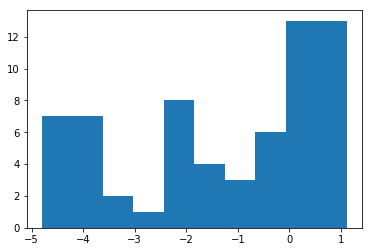

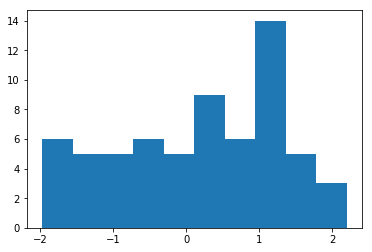

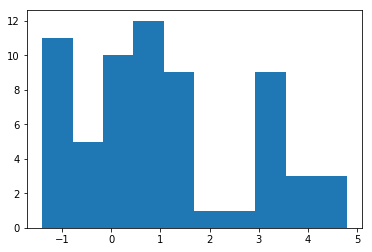

[-1.30132711  0.18542333  1.07594001]
Training epoch 100
Iter: 100
D loss: 0.01982
G_loss: 0.01766
()


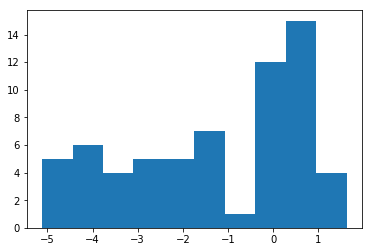

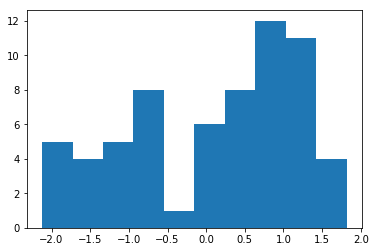

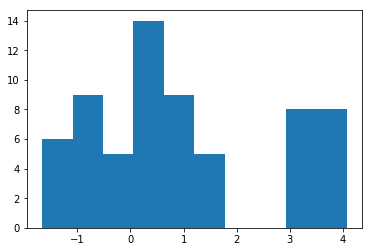

[-1.31420338  0.0982305   0.91644073]
Training epoch 200
Iter: 200
D loss: 0.01734
G_loss: 0.01518
()


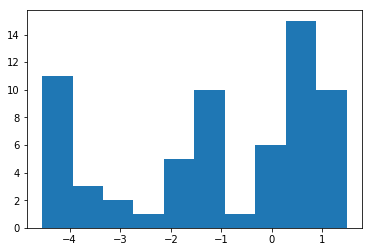

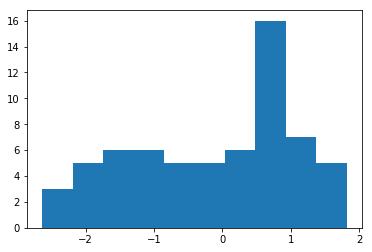

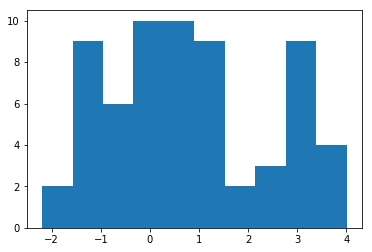

[-1.03601849 -0.09766396  0.80952001]
Training epoch 300
Iter: 300
D loss: 0.01421
G_loss: 0.01188
()


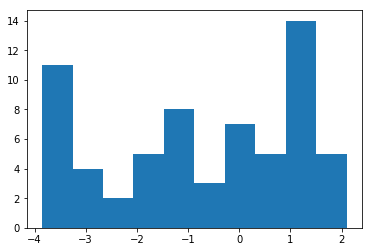

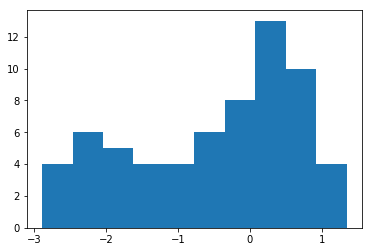

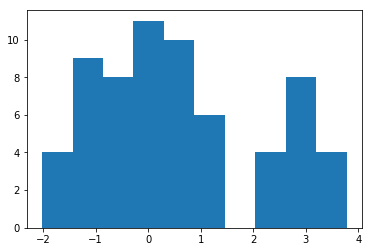

[-0.71485353 -0.51566565  0.5694415 ]
Training epoch 400
Iter: 400
D loss: 0.01283
G_loss: 0.009909
()


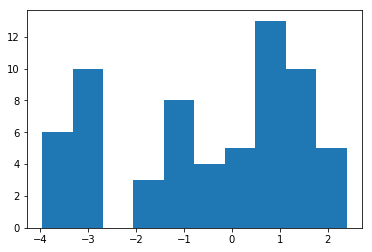

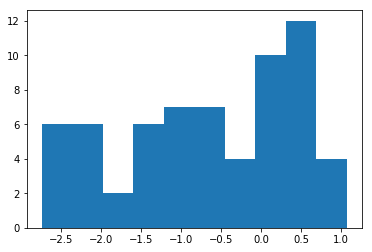

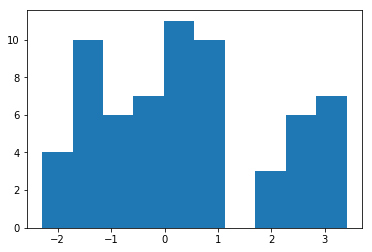

[-0.47331899 -0.68668354  0.41492677]
Training epoch 500
Iter: 500
D loss: 0.01002
G_loss: 0.006708
()


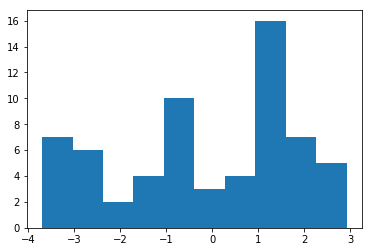

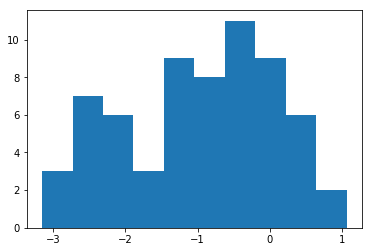

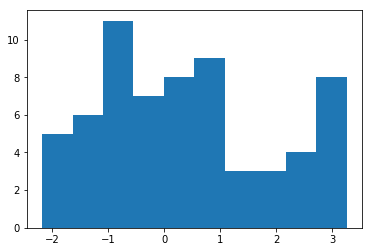

[-0.11978109 -0.95677364  0.36146411]
Training epoch 600
Iter: 600
D loss: 0.008184
G_loss: 0.005165
()


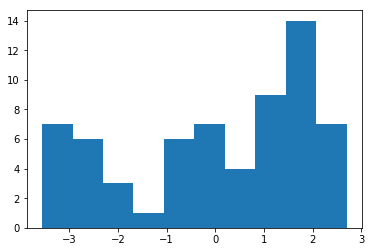

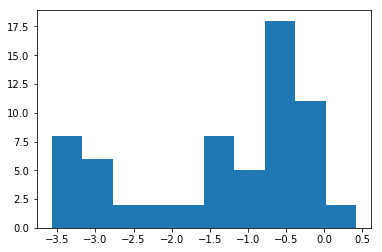

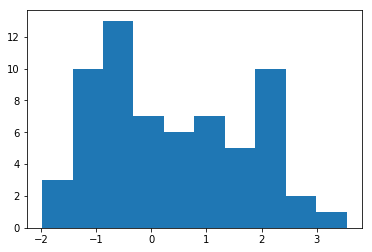

[ 0.07549416 -1.35025263  0.37304261]
Training epoch 700
Iter: 700
D loss: 0.006084
G_loss: 0.00324
()


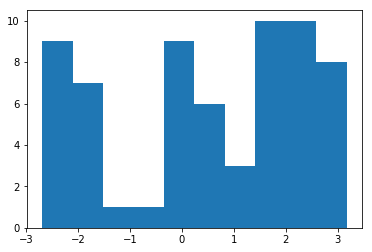

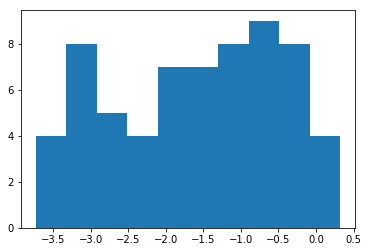

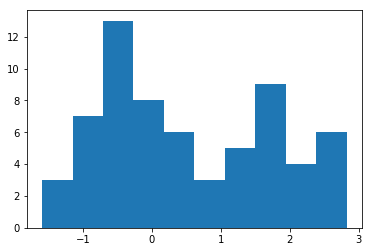

[ 0.54156828 -1.60223603  0.50121295]
Training epoch 800
Iter: 800
D loss: 0.00491
G_loss: 0.002202
()


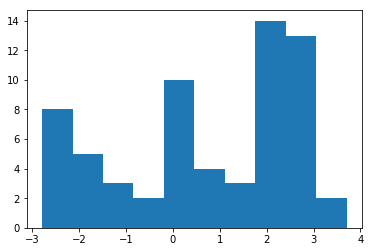

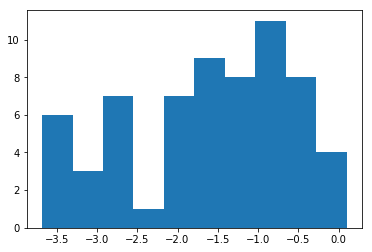

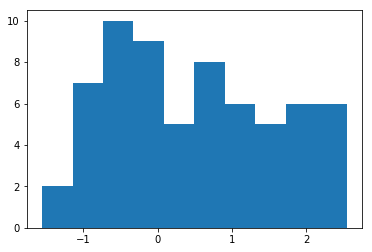

[ 0.71857083 -1.5971539   0.43989319]
Training epoch 900
Iter: 900
D loss: 0.004552
G_loss: 0.003993
()


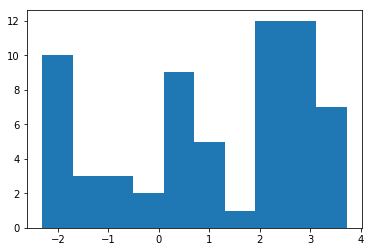

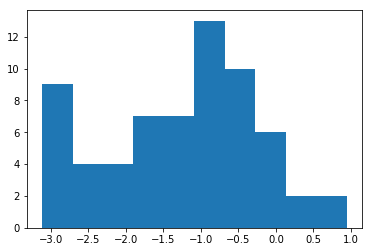

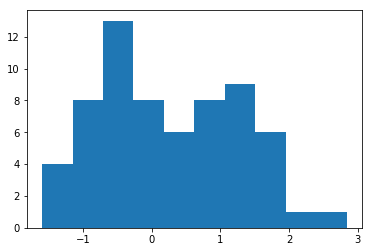

[ 1.03681803 -1.21801603  0.26552609]
Training epoch 1000
Iter: 1000
D loss: 0.004949
G_loss: 0.003944
()


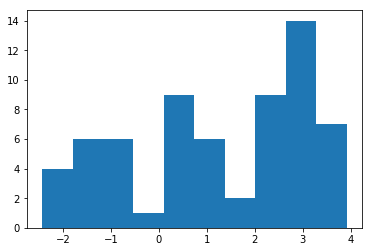

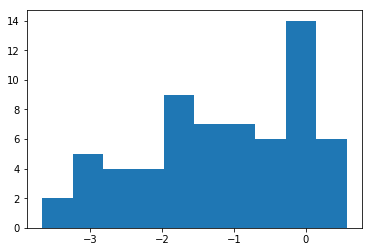

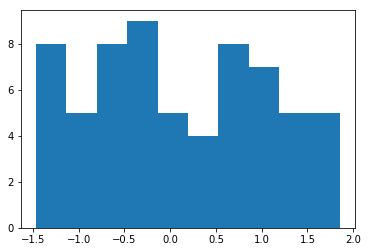

[ 1.20803821 -1.14556003  0.11391169]
Training epoch 1100
Iter: 1100
D loss: 0.00333
G_loss: 0.002158
()


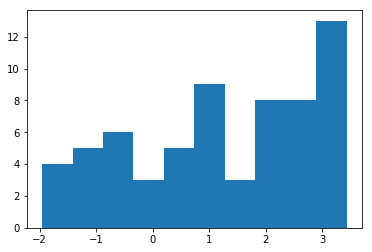

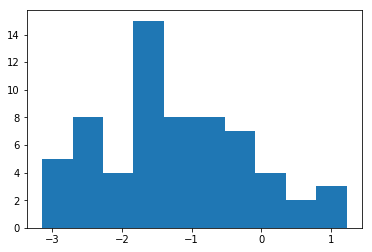

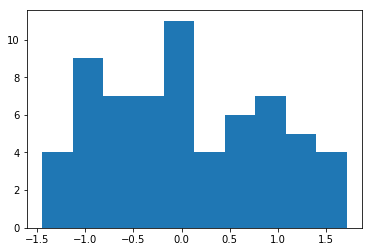

[ 1.21659768 -1.25505292  0.04524595]
Training epoch 1200
Iter: 1200
D loss: 0.003083
G_loss: 0.00151
()


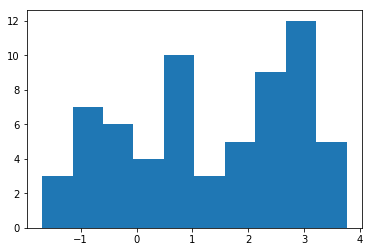

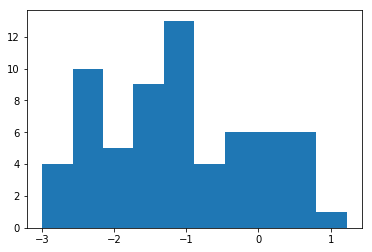

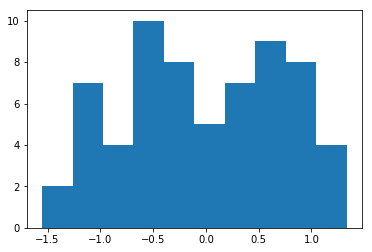

[ 1.28216577 -1.07958174 -0.02440737]
Training epoch 1300
Iter: 1300
D loss: 0.003541
G_loss: 0.002314
()


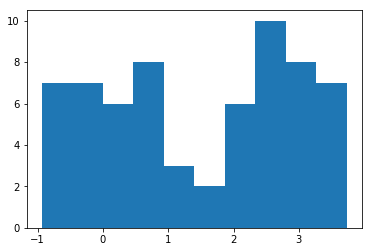

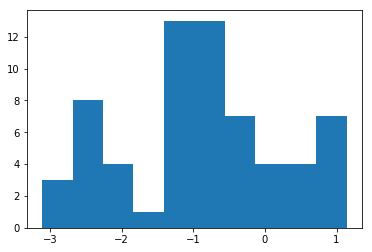

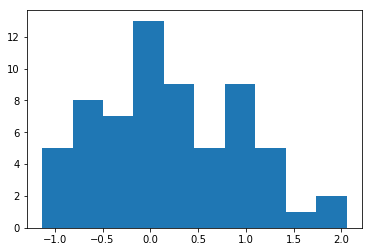

[ 1.44679928 -0.90137827  0.19066785]
Training epoch 1400
Iter: 1400
D loss: 0.002023
G_loss: 0.0003641
()


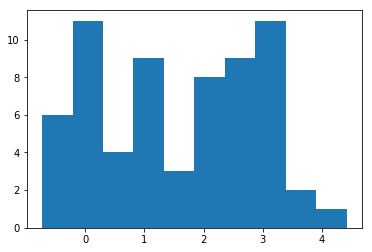

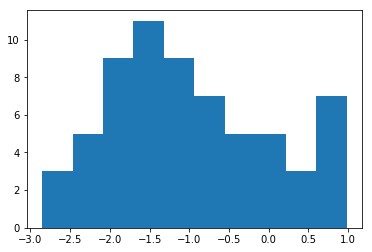

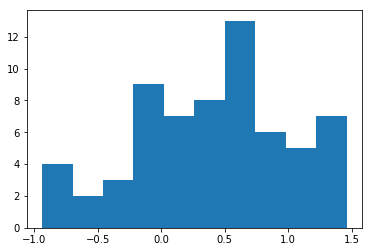

[ 1.54654789 -0.99883056  0.38628727]
Training epoch 1500
Iter: 1500
D loss: 0.00106
G_loss: -0.0009896
()


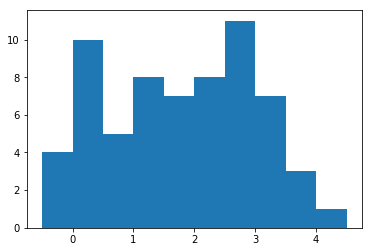

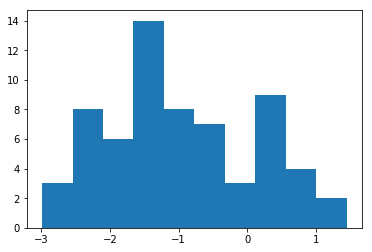

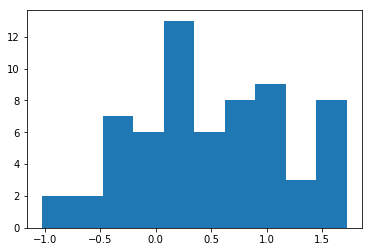

[ 1.79292989 -0.97180986  0.51098967]
Training epoch 1600
Iter: 1600
D loss: 0.002953
G_loss: -0.002461
()


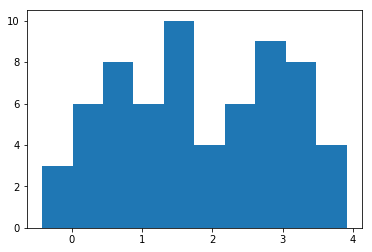

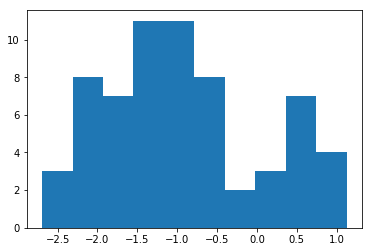

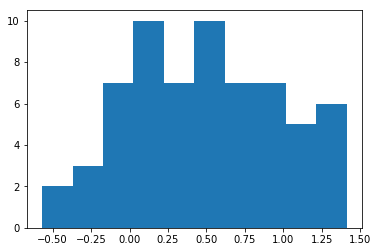

[ 1.82164252 -0.94051939  0.50860089]
Training epoch 1700
Iter: 1700
D loss: 0.008033
G_loss: 0.004372
()


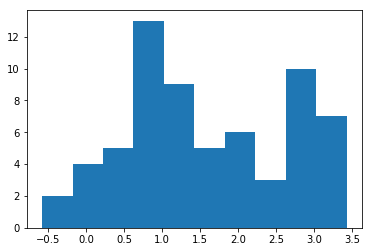

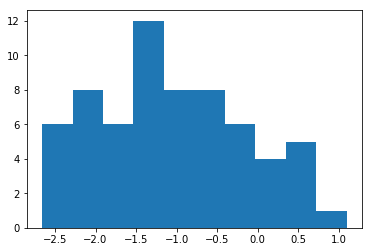

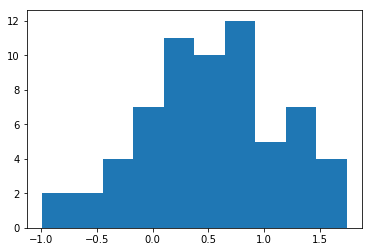

[ 1.58536446 -1.04804301  0.51924175]
Training epoch 1800
Iter: 1800
D loss: 0.006754
G_loss: 0.002748
()


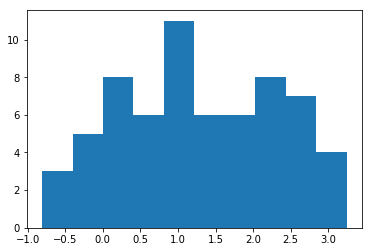

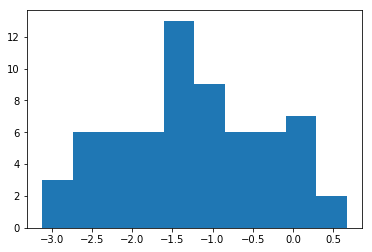

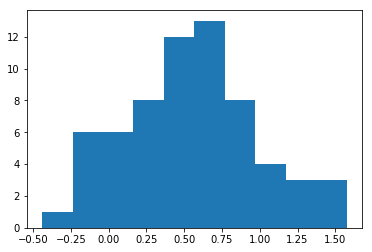

[ 1.26493788 -1.24722457  0.54286826]
Training epoch 1900
Iter: 1900
D loss: 0.005539
G_loss: 0.0007035
()


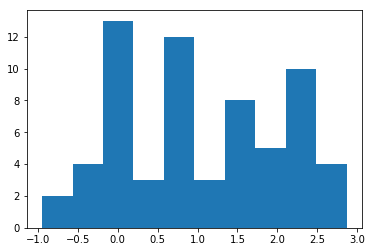

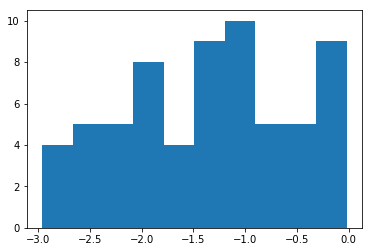

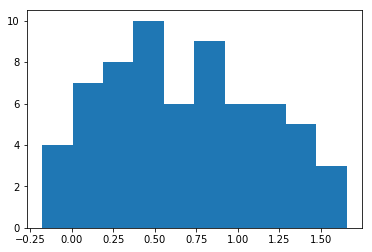

[ 1.01008201 -1.35460746  0.66635871]
Training epoch 2000
Iter: 2000
D loss: 0.004782
G_loss: -0.0006933
()


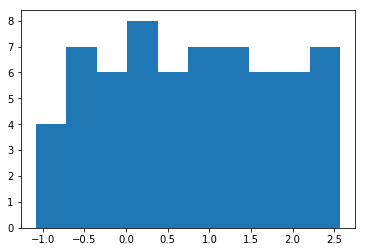

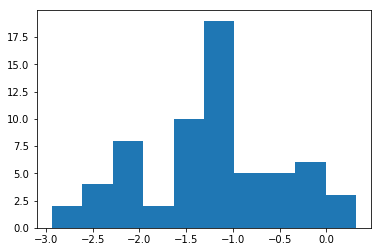

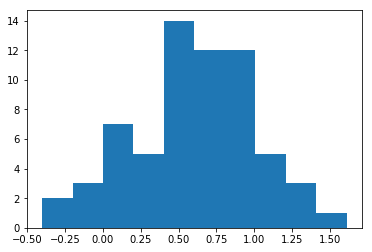

[ 0.78025752 -1.23265254  0.58919692]
Training epoch 2100
Iter: 2100
D loss: 0.004036
G_loss: -0.000306
()


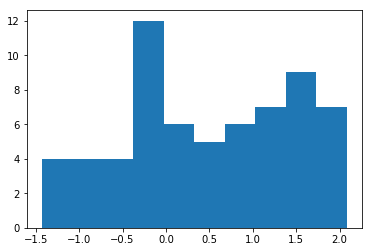

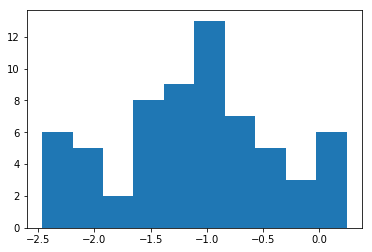

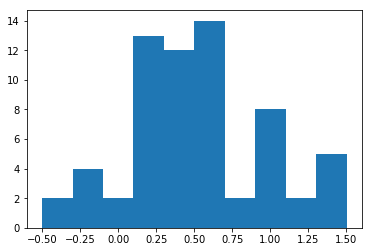

[ 0.49555561 -1.10714269  0.51629198]
Training epoch 2200
Iter: 2200
D loss: 0.002441
G_loss: -0.002929
()


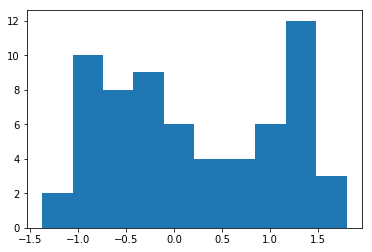

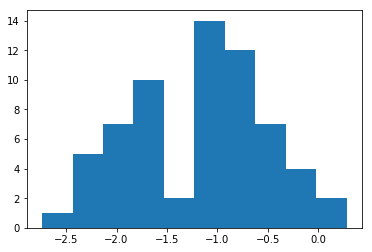

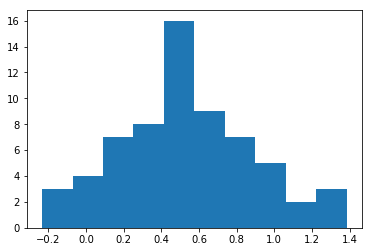

[ 0.20300867 -1.16329014  0.53777868]
Training epoch 2300
Iter: 2300
D loss: 0.001937
G_loss: -0.004058
()


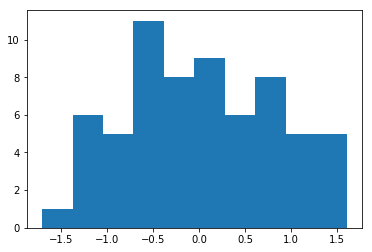

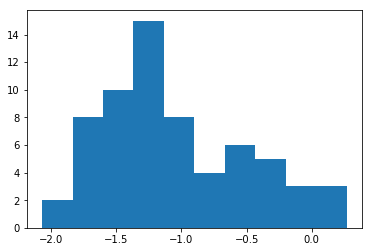

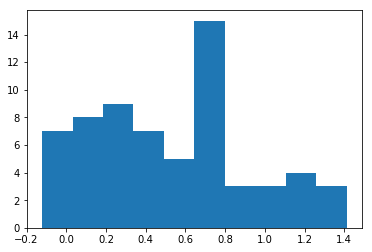

[ 0.02757948 -1.07353973  0.5281412 ]
Training epoch 2400
Iter: 2400
D loss: 0.003768
G_loss: -0.0003566
()


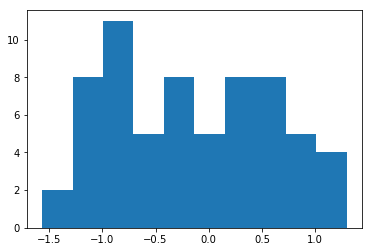

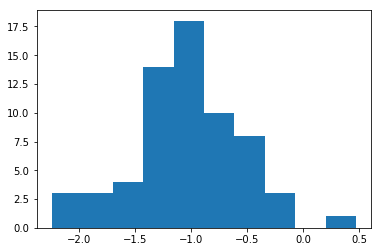

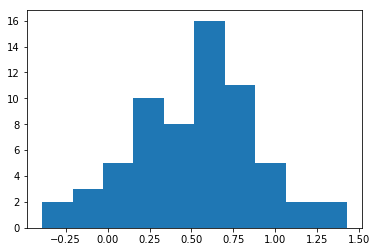

[-0.1604237  -1.03399849  0.51664531]
Training epoch 2500
Iter: 2500
D loss: 0.003976
G_loss: -0.00029
()


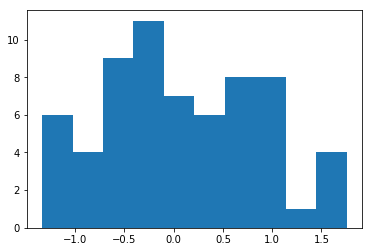

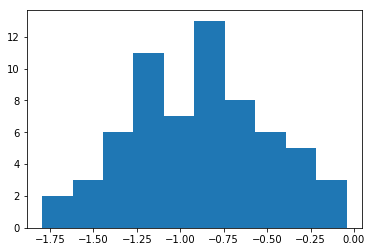

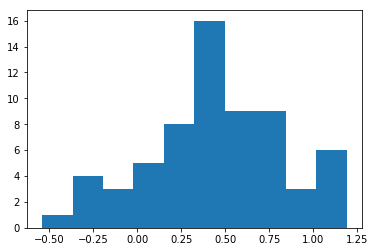

[ 0.06920671 -0.89499158  0.44140276]
Training epoch 2600
Iter: 2600
D loss: 0.002914
G_loss: -0.001571
()


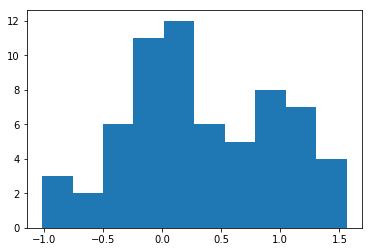

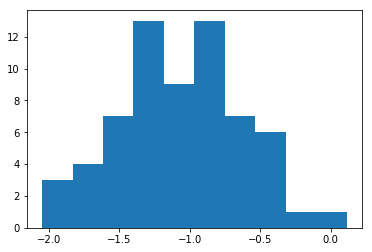

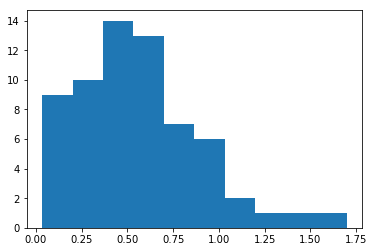

[ 0.34926867 -1.07029819  0.56313717]
Training epoch 2700
Iter: 2700
D loss: 0.002428
G_loss: -0.001861
()


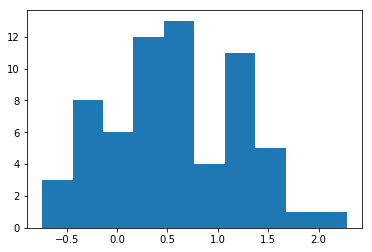

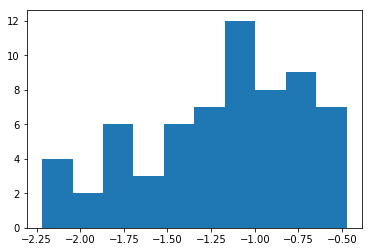

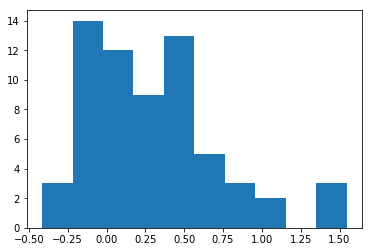

[ 0.57017493 -1.18510818  0.30485779]
Training epoch 2800
Iter: 2800
D loss: 0.002618
G_loss: -0.00168
()


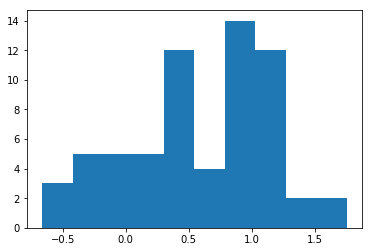

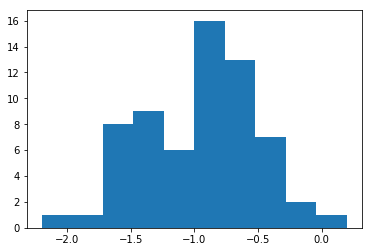

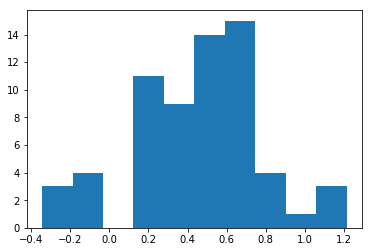

[ 0.58154434 -0.96689051  0.44317442]
Training epoch 2900
Iter: 2900
D loss: 0.001627
G_loss: -0.002505
()


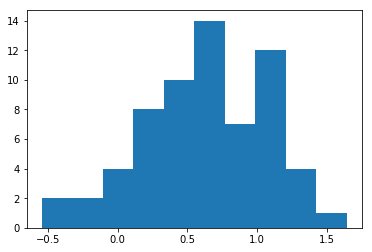

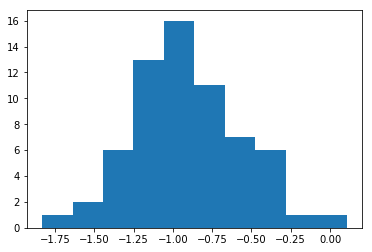

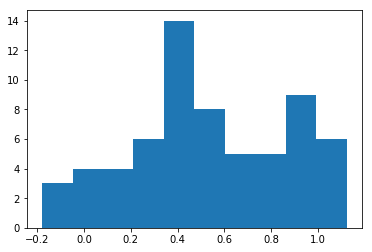

[ 0.63106841 -0.90578157  0.52533048]
Training epoch 3000
Iter: 3000
D loss: 0.001797
G_loss: -0.003126
()


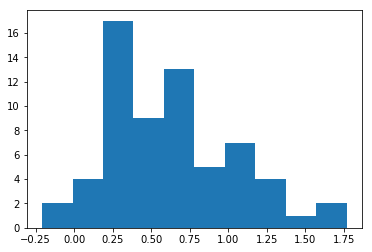

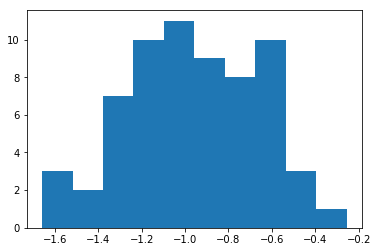

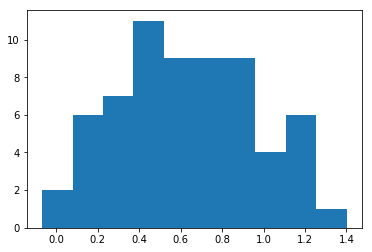

[ 0.63167834 -0.96474922  0.62452638]
Training epoch 3100
Iter: 3100
D loss: 0.001525
G_loss: -0.002937
()


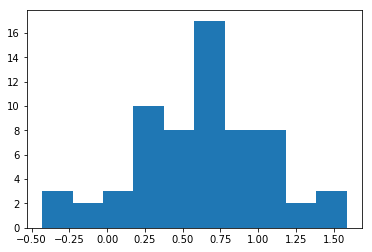

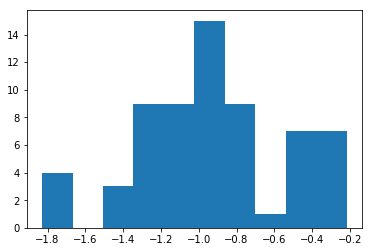

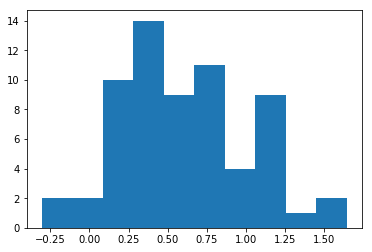

[ 0.63048744 -0.94344193  0.61500883]


KeyboardInterrupt: 

In [15]:
G_pred, G_pred_output_i = generator(z, is_training=False)
G_sample, G_sample_output_i = generator(z, is_training=True)

D_real  = discriminator(label_placeholder)
D_fake  = discriminator(G_sample)

# D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
# G_loss = -tf.reduce_mean(tf.log(D_fake))

# Alternative losses:
# -------------------

#D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=ones_like))
#D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=zeros_like))
#D_loss = D_loss_real + D_loss_fake
#G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=ones_like))

#D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
#D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
#D_loss = D_loss_real + D_loss_fake
#G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

#WGAN:
D_loss = tf.reduce_mean(D_real) - tf.reduce_mean(D_fake)
G_loss = -tf.reduce_mean(D_fake)
clip_D = [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in theta_D]

#D_solver = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(D_loss, var_list=theta_D)
#G_solver = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(G_loss, var_list=theta_G)

D_solver = (tf.train.RMSPropOptimizer(learning_rate=5e-4)
            .minimize(-D_loss, var_list=theta_D))
G_solver = (tf.train.RMSPropOptimizer(learning_rate=5e-4)
            .minimize(G_loss, var_list=theta_G))

mb_size = S

sess = tf.Session()
sess.run(tf.global_variables_initializer())

train_dataset = [features[0] for i in range(0,64)]
n_train = len(train_dataset)
preds = []

d_losses = []
g_losses = []

for it in range(100000):
    if it % 100 == 0:
        print("Training epoch %d" %it)
    batch_sched = list(range(0, n_train+1,S))
    for j in range(0, len(batch_sched)-1):
        start = batch_sched[j]
        stop = batch_sched[j+1]
        feed_dict = construct_feed_dict(train_dataset, start, stop)

        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict=feed_dict)
        
        for _ in range(5):
            feed_dict = construct_feed_dict(train_dataset, start, stop)

            _, D_loss_curr, _ = sess.run(
                [D_solver, D_loss, clip_D],
                feed_dict=feed_dict)
            
        
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict=feed_dict)
        
        d_losses.append(D_loss_curr)
        g_losses.append(G_loss_curr)

        
    if it % 100 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()

        #print("output_i")
        #print(sess.run(G_sample_output_i, feed_dict=feed_dict))
        #print(sess.run(G_sample, feed_dict=feed_dict))

    if it % 100 == 0:
        samples = sess.run(G_sample, feed_dict=feed_dict)
        plt.hist(samples[:,0], bins=10)
        plt.show()
        plt.hist(samples[:,1], bins=10)
        plt.show()
        plt.hist(samples[:,2], bins=10)
        plt.show()
        print(np.mean(samples, axis=0))
        #print(samples[:10])
        #plt.hist(samples, bins=50)
        #plt.show()

In [ ]:
array([ 0.61143659, -0.99900387,  0.48252666])

In [7]:
np.where(feed_dict[dihed_indices][0] != 0)

NameError: name 'np' is not defined

In [8]:
feed_dict[label_placeholder]

NameError: name 'feed_dict' is not defined

In [ ]:
feed_dict[non_zero_inds]

In [ ]:
 [-0.91292151,  3.09695411,  1.06725919,  2.02969492,  1.9801807 , 2.27330438],

In [30]:
features[0][1][1].toarray()

array([[ 0.61143659, -0.99900387,  0.48252666],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.   

In [ ]:
sess.run(G_sample, feed_dict=feed_dict)

In [ ]:
array([[ 0.91292151],
       [ 3.09695411],
       [ 1.06725919],

In [ ]:
plt.hist(sess.run(G_sample, feed_dict=feed_dict))

In [ ]:
batch_sched

In [ ]:
for it in range(20001):
    if it % 100 == 0:
        print("Training epoch %d" %it)
    batch_sched = list(range(0, n_train+1,S))
    for j in range(0, len(batch_sched)-1):
        start = batch_sched[j]
        stop = batch_sched[j+1]
        feed_dict = construct_feed_dict(train_dataset, start, stop)

        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict=feed_dict)
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict=feed_dict)

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()

    if it % 1000 == 0:
        samples = sess.run(G_sample, feed_dict=feed_dict)
        plt.hist(samples, bins=50)
        plt.show()


In [ ]:
preds = []
for k in range(0,100):
    feed_dict = construct_feed_dict(train_dataset, 0, 1)
    samples = sess.run(G_sample, feed_dict=feed_dict)[2]
    preds.append(samples)

In [ ]:
plt.hist(np.concatenate(preds))

In [ ]:
preds[4]

In [ ]:
train_dataset[0][1][1].toarray()

In [ ]:
res = gan.predict()

In [ ]:
res

In [ ]:
plt.hist(res, bins=50)
plt.show()

In [ ]:
features[0][1][1].toarray()

In [ ]:
features[0][1][1].toarray()

In [ ]:
preds = []
for i in range(0,100):
    preds.append(gan.predict(features)[0][2])

In [ ]:
np.mean(preds)

In [ ]:
features[0][2].atom_features